<div align="left" style="float: left;">
    
###### CC2006 - Inteligência Artificial


</div>

<div align="right" style="float: right;">
    
###### _Robert Gleison dos Reis Pereira (up202200496)_  
###### _Sophia Cheto de Queiroz Fonseca (up202200336)_    
###### _Guilherme Magalhães (up202205505)_  

</div>

####
# Decision Tree 

Criação de um modelo de árvore de decisão baseada no algoritmo de indução ID3

_O código completo e comentado da árvore de decisão  se encontra em: 
https://github.com/RobertGleison/decision-tree-ia.git_  
O código desafio de implementação do connect4 utilizando árvore de decisão se encontra em:
https://github.com/RobertGleison/connect4-decision-tree







---


## Introdução  

#### Árvores de Decisão:  
Uma árvore de decisão é um algoritmo de machine learning que utiliza uma estrutura de grafo em forma de árvore para tomar decisões baseadas em dados. Cada nó intermediário realiza uma divisão do conjunto de dados com base em um atributo específico, criando ramos que levam a novos nós ou folhas. Os nós folhas representam os resultados finais ou classes que o modelo aprendeu durante o treinamento. Esse método é amplamente utilizado por sua simplicidade e capacidade de interpretar visualmente o processo de tomada de decisão, facilitando a compreensão de como as conclusões são alcançadas a partir dos dados.

#### O nosso projeto:  
O nosso algoritmo foi desenvolvido em Python, a partir da criação de classes para cada funcionalidade.  
Usamos as seguintes bibliotecas como auxiliares para pré-processamento de dados, análise e apresentação de resultados:  

* Pandas (manipulação de dataframes)  
* Scikit-Learn (análise com cross-validation)
* Pydotplus e IPython (geração de imagens)
* Joblib (armazenamento de objetos)
* Numpy (cálculos e manipulação de dados)  


#### Especificidades da nossa implementação:
* Todos os datasets utilizados devem ter um cabeçalho para cada coluna, representado o nome de um atributo (no caso do connect4.csv, foi necessário criar um manualmente)
* Para os datasets analisados, foi necessário remover colunas de identificação de linhas (IDs) para não ser confundido como um atributo.  
* Para tornar nosso algorítmo universal, fizemos a escolha de considerar todos os atributos numéricos como contínuos, pois não há como saber sem análise prévia, se um valor inteiro representa algo categorico.


---

# Estrutura do projeto:


<div align="left">
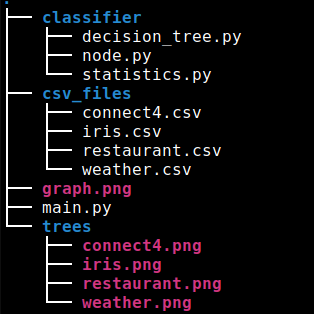
</div>


####  Armazenamento nos Diretórios
* **csv_files:** datasets utilizados em formato csv  
* **classifier:** códigos de implementação e avaliação da árvore
* **trees:** imagens finais das árvores geradas para cada dataset
* **main.py:** código final que roda o programa completo  
* **graph.png:** imagem da última árvore gerada ao rodar o programa

---

## **Árvore de Decisão**

Antes de desenvolver os algoritmos criados, precisamos importar as bibliotecas usadas por todo o código:

In [ ]:
# !pip install pydotplus # Descomentar para baixar dependência

In [3]:
import pandas as pd
import numpy as np
import pydotplus
import time
from pandas import DataFrame
from joblib import load, dump
from sklearn.model_selection import LeaveOneOut, KFold, train_test_split

### node.py
Código para cada nó utilizado na árvore de decisão. São as estruturas de armazenamento de dados durante todo o processo.

In [5]:
class Node:
    def __init__(self, dataset: DataFrame, children=None, value=None, info_gain=None, feature_name=None, split_type=None, is_leaf=False) -> None:
        self.dataset = dataset                              
        self.size = len(dataset)                            
        self.is_leaf = is_leaf
        self.ispure = len(set(dataset.iloc[:,-1]))==1
        self.value = value                                                                            
        self.feature_name = feature_name                    
        self.split_type = split_type                        
        self.children = children                            
        self.info_gain = info_gain                          

Atributos:  

* **dataset**: linhas do dataset presentes em um nó.
* **size**: quantidade de samples em um nó
* **ispure**: se o nó é puro (só recebeu samples com o mesma classe target, sem precisar fazer voto de maioria)
* **value**: se for folha, valor da classe target majoritária; se for nó, armazena os valores de divisão entre os filhos (threshold ou valores da feature do split)
* **feature_name**: feature usada na divisão entre os filhos
* **split_type**: tipo da divisão entre os filhos ("discrete" ou "continuous")
* **children**: lista dos nós-filhos do nó atual
* **info_gain**: information gain obtido na divisão entre os filhos

### decision_tree.py
Na implementação da árvore de decisão, criamos as seguintes estruturas:

* Atributos:  
    * **root**: nó raiz da árvore
    * **dataset**: dataset base utilizado na árvore
    * **min_samples**: quantidade mínima de samples num nó para que ocorra um split. Caso um nó atinja esse número, vira um nó folha.
    * **feature_types**: dicionário que relaciona o nome de cada coluna com o seu respectivo tipo (discreto ou contínuo)
* Funções:
    * **fit()**: treinar a árvore de acordo com o dataset passado como argumento
    * **predict()**: calcula a previsão de classe para novas linhas de dataset do argumento
* Funções internas auxiliares

In [6]:
# @dataclass
class DecisionTree:

    def __init__(self, dataset: DataFrame, max_depth: int = 100, min_samples: int = 0) -> None:
        def fill_types(dataset: pd.DataFrame):
            def mapping(tuplo):
                if tuplo[1] in [np.int64, np.float64]: return (tuplo[0], 'continuous')
                else: return (tuplo[0],'discrete')
            return dict(map(mapping, zip(dataset.columns, dataset.dtypes)))
        
        self.root: Node = None
        self.dataset: DataFrame = dataset
        self.max_depth: int = max_depth 
        self.min_samples: int = min_samples
        self.feature_types = fill_types(dataset)

    def __str__(self) -> str:
        return self.toString(self.root, "")

    def fit(self, dataset: DataFrame):
        '''Fit the tree with a trainning DataFrame'''
        self.root = self.build_tree(dataset)

    def build_tree(self, dataset: DataFrame, depth: int = 0) -> Node:
        '''Build the Decision Tree from the root node'''
        def calculate_leaf_value(targets: DataFrame):
            '''Get value of the majority of results in a leaf node'''
            target = list(targets)
            uniques = set(target)
            counting = [(target.count(item), item) for item in uniques]
            max_value = max(counting)[1]
            return max_value
        
        # print(depth)
        
        features = dataset.iloc[:,:-1]
        targets = dataset.iloc[:,-1]
        num_samples = len(dataset)

        # reaches the limit of the tree
        ispure = (len(set(targets)) == 1)
        if num_samples < self.min_samples or depth == self.max_depth or ispure or len(features.columns)==0 or num_samples==0:   ########## mudei
            return Node(value=calculate_leaf_value(targets), is_leaf=True, dataset=dataset)
        
        best_split = self.get_best_split(dataset)

        if best_split == {}: 
            return Node(value=calculate_leaf_value(targets), is_leaf=True, dataset=dataset)

        children = []
        for child in best_split["children"]:
            if len(child) == 0: 
                children.append(Node(value=calculate_leaf_value(targets), is_leaf=True, dataset=child))
            else: 
                children.append(self.build_tree(child, depth+1))
        return Node(dataset, children, best_split["value"], best_split["info_gain"], best_split["feature_name"], best_split["split_type"])
    

    def get_best_split(self, dataset: DataFrame):
        '''Get the best split for a node'''
        best_split = {}
        max_infogain = 0
        features = dataset.iloc[:,:-1]
        targets = dataset.iloc[:, -1]

        for feature_name in features.columns:
            values = self.dataset[feature_name]
            feature_type = self.feature_types[feature_name]
            parent_entropy = self.entropy(targets) 

            if feature_type == 'discrete':
                children, info_gain = self.discrete_split(dataset, feature_name, pd.unique(values), targets, parent_entropy)
                max_infogain = self.update_best_split(best_split, info_gain, max_infogain, feature_type, children, pd.unique(values.map(lambda x: str(x))), feature_name)
                continue

            for value in pd.unique(values):
                children, info_gain = self.continuous_split(dataset, feature_name, value, targets, parent_entropy)
                max_infogain = self.update_best_split(best_split, info_gain, max_infogain, feature_type, children, value, feature_name)

        return best_split
    
    def update_best_split(self, best_split: dict, info_gain: float, max_infogain: float, feature_type: str, children: list, value: any, feature_name: str):
        if info_gain > max_infogain:
            best_split["feature_name"] = feature_name
            best_split["value"] = value
            best_split["split_type"] = feature_type
            best_split["children"] = children
            best_split["info_gain"] = info_gain
            return info_gain
        return max_infogain
    
    def continuous_split(self, dataset: DataFrame, feature_name, threshold, targets, parent_entropy):
        left = dataset[dataset[feature_name] <= threshold].copy()
        right = dataset[dataset[feature_name] > threshold].copy()
        left.drop([feature_name], axis=1, inplace=True)
        right.drop([feature_name], axis=1, inplace=True)
        children = [left, right]
        info_gain = self.info_gain(dataset, children, targets, parent_entropy)
        return children, info_gain
    
    def discrete_split(self, dataset: DataFrame, feature_name, values, targets, parent_entropy):
        labels = list(values)
        children = []
        for label in labels: 
            child_dataset = dataset[dataset[feature_name] == label].copy()
            child_dataset.drop([feature_name], axis=1, inplace=True)
            children.append(child_dataset)
        info_gain = self.info_gain(dataset, children, targets, parent_entropy)
        return children, info_gain
    
    def info_gain(self, parent_dataset: DataFrame, children: list[DataFrame], parent_targets: DataFrame, parent_entropy):
        parent_length = len(parent_dataset)
        children_entropy = np.sum([(len(child_dataset) / parent_length) * self.entropy(child_dataset.iloc[:, -1]) for child_dataset in children])
        return parent_entropy - children_entropy


    def entropy(self, targets) -> float:
        '''Get the entropy value for a node'''
        counts = targets.value_counts()
        probs = counts/len(targets)
        return np.sum(-probs * np.log2(probs))
    

    def predict(self, X_test: DataFrame) -> list:
        '''Predict target column for a dataframe'''
        return [self.make_prediction(row, self.root) for _, row in X_test.iterrows()]


    def make_prediction(self, row: tuple, node: Node):
        '''Predict target for each row in dataframe'''
        if node.is_leaf: 
            return node.value
        
        value = row[node.feature_name]

        if node.split_type == 'discrete': 
            for i, node_value in enumerate(node.value):
                if value == node_value:
                    return self.make_prediction(row, node.children[i])  
        
        elif node.split_type == 'continuous':
            if value <= node.value:
                return self.make_prediction(row, node.children[0])  
            return self.make_prediction(row, node.children[1])

        return None


    def toString(self, node: Node, indent: str):
        string = ""
        if not node.children:
            return string
        
        add = " " * 5
        string += indent + f"<{node.feature_name}>" + "\n"
        indent += add

        for i in range(len(node.children)):
            child = node.children[i]

            if type(node.value) in [np.int64, np.float64]:
                if i==0: simbolo="<="
                else: simbolo=">"
                if child.is_leaf: #se for folha
                    string += indent + f"value {simbolo} {node.value}: {child.value} ({child.size})" + "\n"
                else:
                    string += indent + f"value {simbolo} {node.value}:" + "\n"
                    string += self.toString(child, indent+add)
            
            else: 
                if child.is_leaf: #se for folha
                    string += indent + f"{node.value[i]}: {child.value} ({child.size})" + "\n"  # valor da feature: valor da folha (qtd de linhas)
                else:
                    string += indent + f"{node.value[i]}:" + "\n"
                    string += self.toString(child, indent+add)
        
        return string

       

#### Treinamento (fit)

A partir do dataset fornecido como argumento, criamos um novo nó raiz que inicia o processo de construção da árvore (chamando a função build_tree).
Nessa função, avaliamos todas as possíveis features para determinar o melhor split para esse nó, simulando um split para cada feature (usando a função get_best_split). Cada simulação é comparada com base no ganho de informação (information gain), e a feature que proporcionar o maior ganho de informação é escolhida. Em seguida, criamos novos nós filhos, dividindo o dataset utilizando a feature escolhida, e repetimos o processo recursivamente para cada novo nó.

Para identificar se um nó é um nó-folha, fazemos as seguintes checagens e verificamos se alguma é verdade:
* Se o nó for puro (contiver apenas um tipo de classe alvo).
* Se não houver mais features (colunas) a serem analisadas, pois os nós-pais já utilizaram todas nas classificações anteriores.
* Se o nó possuir uma quantidade de samples menor ou igual aovalor do _min_samples_ da árvore.


##### Split Discreto
Para features com valores categóricos/discretos, criamos um nó filho para cada valor possível que o atributo pode assumir. Portanto, um atributo categórico com N valores distintos geraria N nós filhos. Após dividir os sub-datasets pertencentes a cada filho, removemos a coluna da feature utilizada nesse split para garantir que ela não será reutilizada como parâmetro de divisão ao longo da construção da árvore. 

##### Split Contínuo
Para colunas com valores numéricos, assumimos uma relação de ordem entre os valores. Assim, dividimos o dataset atual em dois subconjuntos: um contendo as linhas com valores menores que um threshold e outro contendo as linhas com valores maiores que esse threshold.
Para determinar o melhor threshold, simulamos um split teste para cada valor possível dessa feature e utilizamos aquele que obteve o maior ganho de informação.

#### Previsão (predict)

Após o treinamento da árvore, podemos aplicar a função predict em novas linhas do dataset para prever suas classes.
Para cada nó da árvore, começando pelo nó raiz, lemos o valor correspondente à feature usada para o split em cada linha de dados em questão e separamos as linhas com base nesse valor. Assim, percorremos a árvore através dos nós filhos de acordo com esses valores até chegarmos a uma folha, onde retornamos o valor da classe.

---


## **Análise Estatística** 


### statistics.py

Para as análises estatísticas da performance da Árvore de Decisão com os diferentes datasets, criamos as seguintes funções para essa classe:

In [13]:
class StatisticalAnalysis:
    def __init__(self, dataframe: DataFrame) -> None:
        # self.dt = DecisionTree(dataframe=dataframe, min_samples=samples, max_depth=depth)
        self.df = dataframe
        self.target_data = self.df.iloc[:,-1]
        self.features_data = self.df.iloc[:,:-1]
        self.analysis()


    def analysis(self):
        if len(self.df)<50:
            accuracies, test_size = self._leave_one_out_cross_validation()
            print(f"\nCross validation type: Leave One Out")
        else:
            accuracies, test_size = self._k_fold_cross_validation()
            print(f"\nCross validation type: K-Fold")
        mean_accuracy = sum(accuracies) / len(accuracies)
        self._print_statistics(mean_accuracy, test_size)

        accuracies, test_size = self.general_analysis()
        mean_accuracy = sum(accuracies) / len(accuracies)
        self.print_analysis(mean_accuracy, test_size)


    def general_analysis(self):
        accuracies = []
        dt = DecisionTree(self.df)
        for i in range (35,45):
            train, test = train_test_split(self.df, test_size=0.3, random_state=i)
            dt = DecisionTree(self.df)
            dt.fit(train)

            target_test = test.iloc[:,-1]
            predictions = dt.predict(test)
            accuracies.append(self._accuracy_score(target_test, predictions))
        return accuracies, target_test.shape[0]

        
    def _leave_one_out_cross_validation(self) -> tuple[list, int]:
        loo = LeaveOneOut()
        accuracies = []
        for train_index, test_index in loo.split(self.features_data):
            X_train, X_test = self.features_data.iloc[train_index], self.features_data.iloc[test_index]
            y_train, y_test = self.target_data.iloc[train_index], self.target_data.iloc[test_index]
            
            dt = DecisionTree(self.df)
            df = pd.concat([X_train, y_train], axis=1)
            dt.fit(df)
            y_pred = dt.predict(X_test)
            accuracies.append(self._accuracy_score(y_test, y_pred)) 
        return accuracies, y_test.shape[0]
    
    
    def _k_fold_cross_validation(self, n_test: int = 10) -> tuple[list, int]:
        kf = KFold(n_splits=n_test)
        accuracies = []

        for train_index, test_index in kf.split(self.features_data):
            X_train, X_test = self.features_data.iloc[train_index], self.features_data.iloc[test_index]
            y_train, y_test = self.target_data.iloc[train_index], self.target_data.iloc[test_index]

            dt = DecisionTree(self.df)
            df = pd.concat([X_train, y_train], axis=1)
            dt.fit(df)
            y_pred = dt.predict(X_test)
            accuracies.append(self._accuracy_score(y_test, y_pred))
        return accuracies, y_test.shape[0]
    

    def _accuracy_score(self, y_test, y_pred) -> float:
        total_counter = 0
        right_predictions = 0
        for i in range(len(y_test)):
            if y_pred[i] == y_test.iloc[i]: right_predictions += 1
            total_counter += 1
        return right_predictions / total_counter
    

    def print_analysis(self, mean_accuracy, test_size):
        print("Teste geral:")
        print(f"Model test size: {test_size} rows")
        print(f"Model train size: {len(self.df) - test_size} rows")
        print(f"Model accuracy: {(mean_accuracy * 100):.2f}%\n\n" )


    def _print_statistics(self, mean_accuracy: float, test_size: int) -> None:
        print(f"Model test size: {test_size} rows")
        print(f"Model train size: {len(self.df) - test_size} rows")
        print(f"Model accuracy: {(mean_accuracy * 100):.2f}%\n\n" )

**Teste Geral**:  
A análise sem cross-validation é feita a partir da separação de 70% do dataset para o treino e 30% para teste. Após, aplicamos o fit() e o predict() sobre a árvore usando seus respectivos datasets.  
Repetimos o processo para diferentes seed de aleatoriedade (_random_state_) para a divisão dos dados e, ao final, retornamos a média das accuracies obtidas.  

**K-Fold**:  
Para datasets com mais de 50 linhas, utilizamos o método de Cross-Validation K-Fold. Nesse método, dividimos o dataset em K subdatasets. Em cada iteração, utilizamos um desses subdatasets como Test Set e os demais como Training Set. Esse processo é repetido K vezes, cada vez com uma separação diferente. Ao final, calculamos a média das accuracies obtidas em cada iteração para obter uma estimativa mais robusta do desempenho do modelo.

**Leave One Out**:  
Quando lidamos com datasets menores, cada conjunto de linhas gerado no K-Fold pode representar uma parte significativa do dataset, o que poderia resultar em uma análise desbalanceada em cada iteração.
Portanto, para casos em que o dataset é pequeno (possui menos de 50 linhas), aplicamos o método de Cross-Validation Leave One Out.
Seu funcionamento é semelhante ao K-Fold, porém, em cada iteração, o Test Set consiste apenas de uma linha do dataset. Isso nos permite avaliar o modelo de forma mais precisa e robusta em conjuntos de dados pequenos.    
  
  
  
#### **Considerações**
Nos dois casos de Cross-Validation, a etapa de separação do Test Set e do Training Set contém aleatoriedade do próprio programa, que escolhe randomicamente onde ocorrerá cada divisão. Assim, a accuracy média de cada programa pode assumir valores diferentes a cada vez que o programa for rodado.

---

## Análise dos Datasets

**Legenda para leitura das imagens:**
- Nós cinzentos são nós intermediários e nós coloridos são folhas.
- O valor dentro de cada nó intermediário refere-se a qual atributo é usado como referência para o split.
- O valor em cada aresta representa como o dataset foi separado utilizando a feature analisada no nó.
- Os números associados a cada nó representam o número de amostras do dataset original presentes.
- Os números com asteriscos referem-se aos nós folhas puros, que não precisaram de voto majoritário.

### Restaurant.csv


<div align="center">
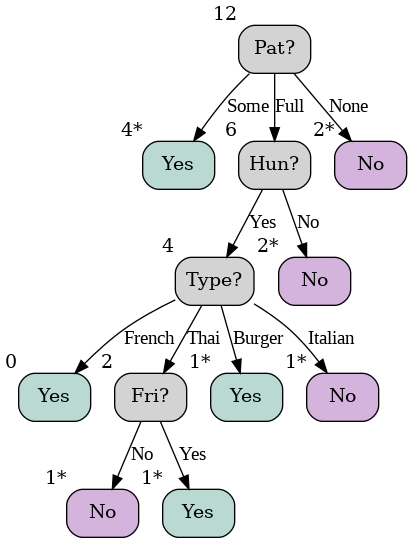
</div>

Inicialmente, apenas ao analisar a árvore da imagem já é possível perceber que a escolhe de features foi bem feita, uma vez que cada divisão gera ao menos um nó folha, o que demonstra que o dataset está sendo bem dividido e a entropia está realmente diminuindo de acordo com a descida pela árvore.  
Um ponto importante também é que a folha com o valor "French" da feature "Type" é construída com um valor bem definido, mesmo que nenhum sample chegue até ela. Isso ocorre pois não há nenhuma linha do dataset com os atributos "Full" no Pat, "Yes" para Hun e "French" no Type. Assim, a folha assume o valor da maioria das classes do seu nó pai.

#### Análise Estatística


Por ser um dataset com poucas informações, cada folha abrange um número muito pequeno de linhas, o que torna a árvore muito específica para os dados já existentes, representando pouco um padrão real.  
Então, ao criar árvores de teste com menos linhas que o total, as linhas retiradas já deixam a árvore muito desbalanceada, o que torna a accuracy dos testes mais baixa, por mais que a árvore siga o padrão esperado.

### Weather.csv


<div align="center">
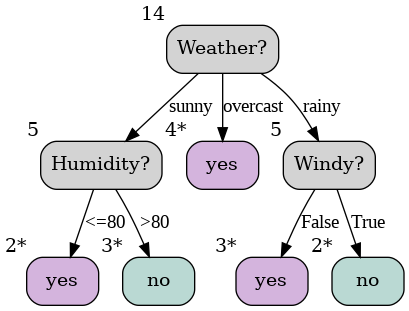
</div>

Para a divisão de features com valores numéricos, como Humidity, utilizamos um dos valores dessa coluna como divisor (threshold).  
A utilização de apenas um threshold se mostrou suficientemente satisfatória para os datasets disponíveis, então, por exigir menos computabilidade, optamos por manter essa quantidade.

#### Análise Estatística


Assim como no caso do Restaurante, o dataset do Weather também possui uma pequena quantidade de informações, então é esperado, pelo mesmo motivo, que a accuracy medida seja também mais baixa.

### Iris.csv

<div align="center">
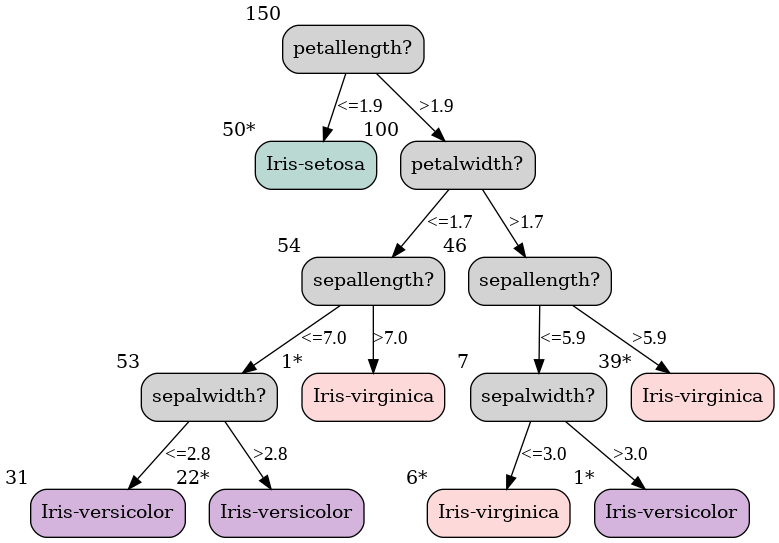
</div>

Esse dataset, por possuir uma quantidade muito maior de informações, já consegue extrair dos dados um padrão de classificação em vez de se adequar apenas às informações já especificadas.  
Por conta disso, devemos analisar a performance da árvore para evitar que ocorra um overfitting da árvore. Para isso, podemos modificar o parâmetro _min_samples_ e observar o comportamento da accuracy de acordo com cada valor, como feito no gráfico abaixo:

<div align="center">
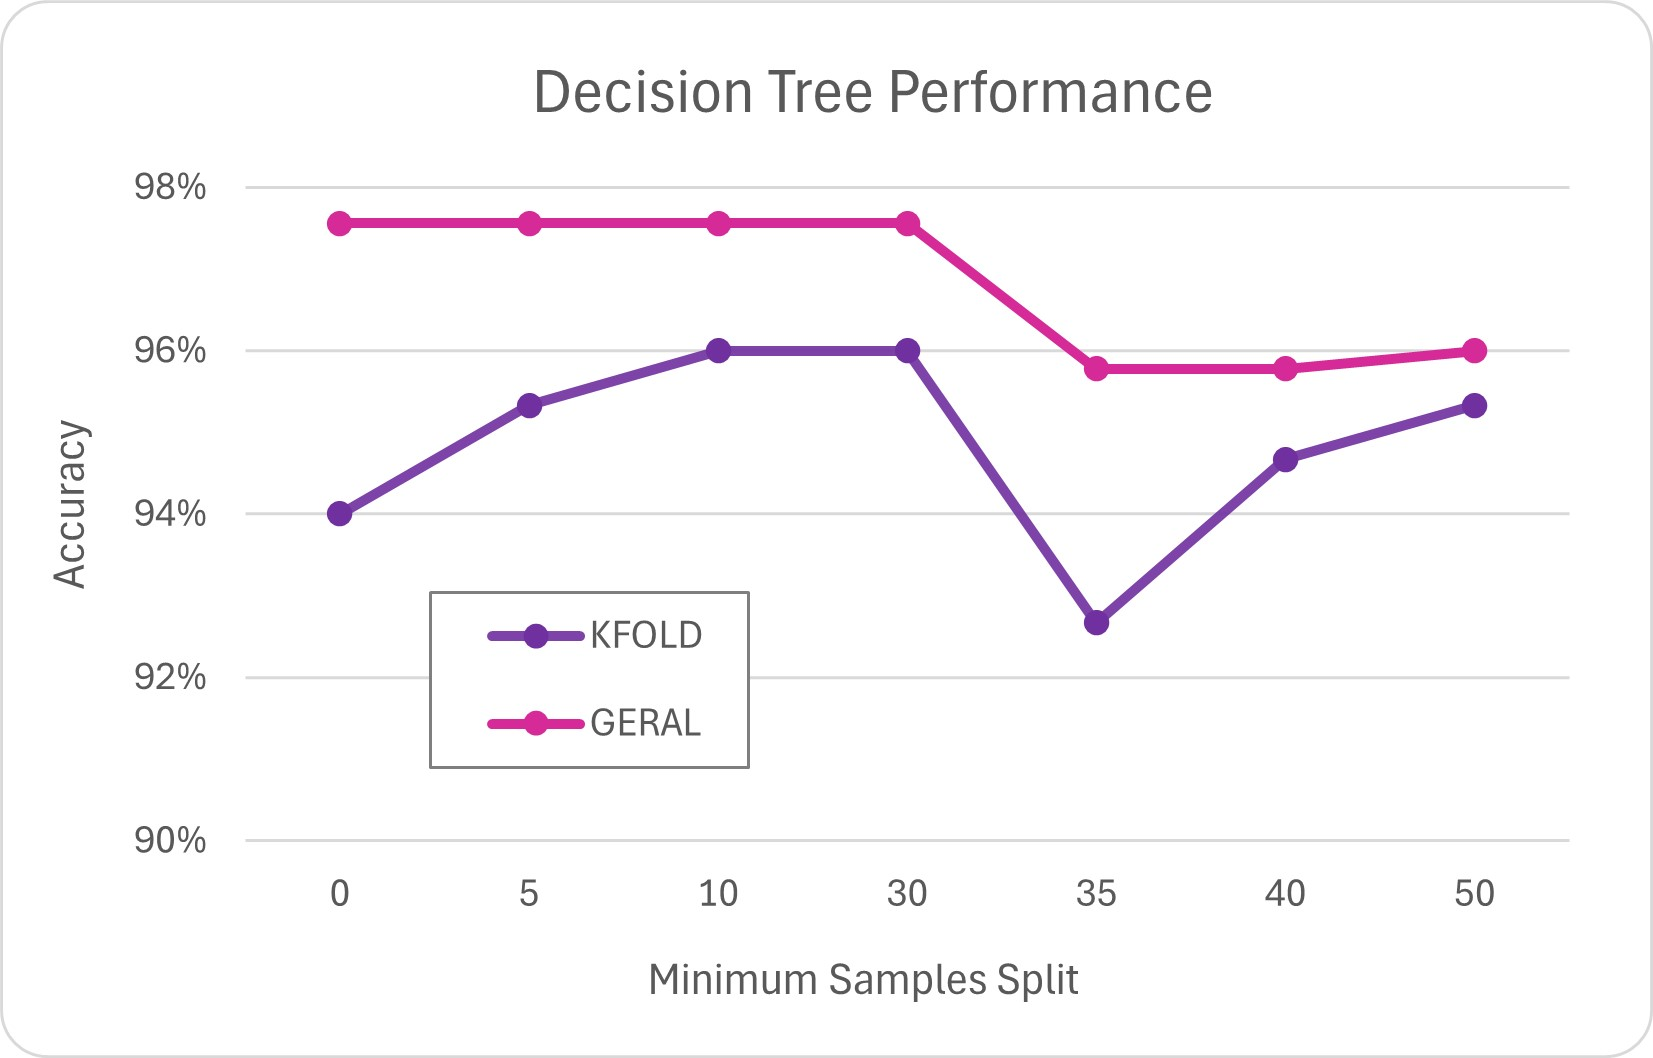
</div>

Percebe-se que o ponto com _min_samples_ = 10 possui uma boa perfomance, em ambos os tipos de análise. A sua árvore é a seguinte:

<div align="center">
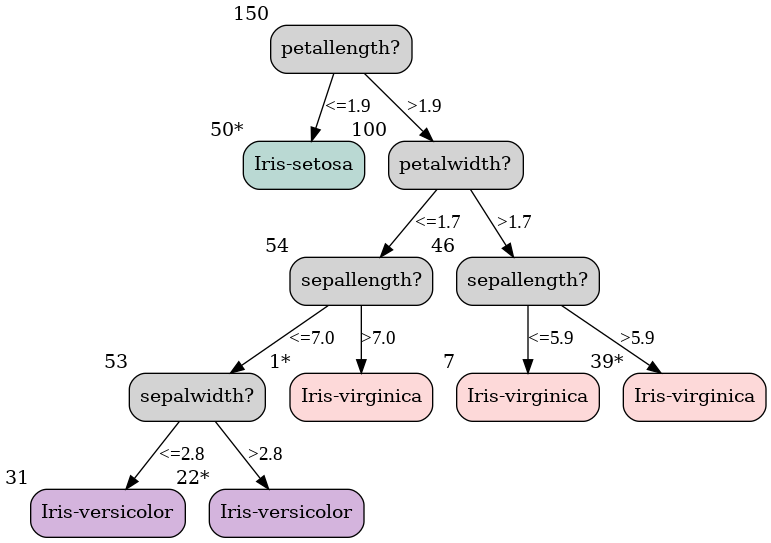
</div>

Ao analisar as duas árvores, percebe-se que o que ocorre é que a folha mais à direita da árvore inicial é na verdade um ruído (outlier), mas nela é considerado como um padrão.  
Ao adicionarmos um limite ao _min_samples_ passamos a considerá-lo apenas como um ruído e a classificação de Iris-virginica passa a englobá-lo.

#### Análise Estatística


### Connect4.csv

Devido à grande quantidade de dados desse dataset, o treinamento da árvore passa a levar muito tempo para ser finalizado. Por conta disso, optamos guardar o objeto árvore num arquivo joblib que é carregado apenas para realizarmos o predict() durante a execução do programa.

<div align="center">
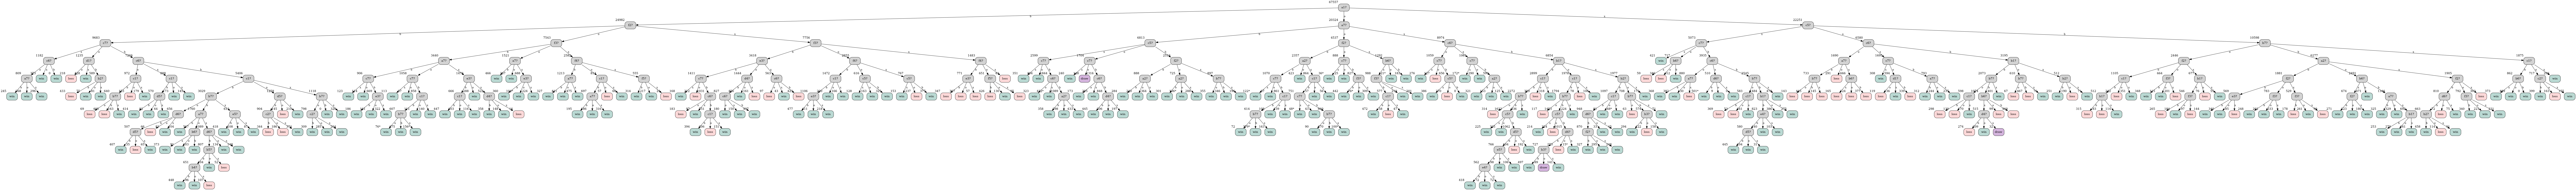
</div>

Inicialmente, ao separar o dataset nas diferentes classes existentes, foi observado a seguinte quantidade para cada valor:

A quantidade de linhas com "Win" é quase 2/3 de todo o conjunto de dados. Por conta disso, a árvore encontra-se muito desbalanceada. Ou seja, ao encontrar novos dados nunca testados pela árvore, há muito maior probabilidade da previsão ser um "win". A partir disso, já é esperado que os resultados da análise estatística e da aplicação da Decision Tree no jogo sejam afetadas.  

#### Análise Estatística


Devido ao tempo de execução para esse dataset, não conseguimos aplicar as funções de análise estatística sobre a árvore sem limite de _min_samples_, então inicialmente aplicamos um limite de 500.

Como o valor da accuracy ainda estava baixo, tentamos analisar um limite que entregasse um resultado satisfatório:

<div align="center">
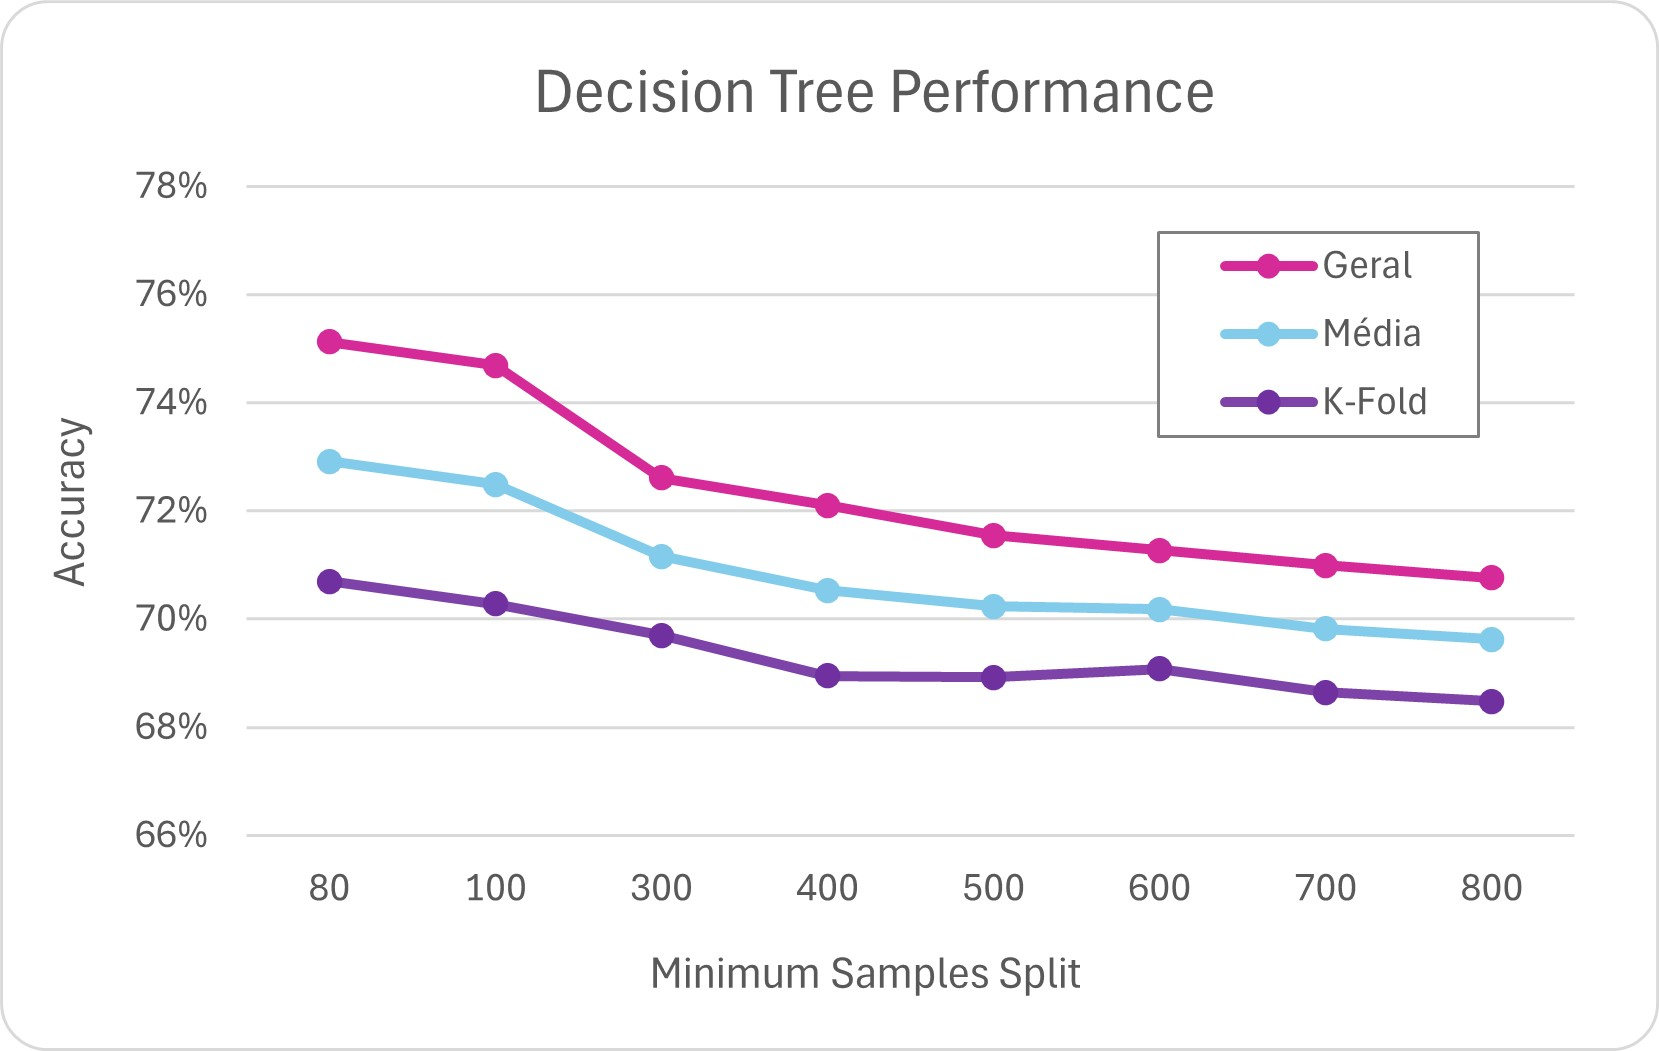
</div>


Percebe-se que com o _min_samples_ a partir de 100 já conseguimos perceber uma grande melhora na accuracy. Para conferir essa perfomance, comparamos a árvore inicial obtida com uma com limite 100, mudando a quantidade de folds usados no Cross Validation:

<div align="center">
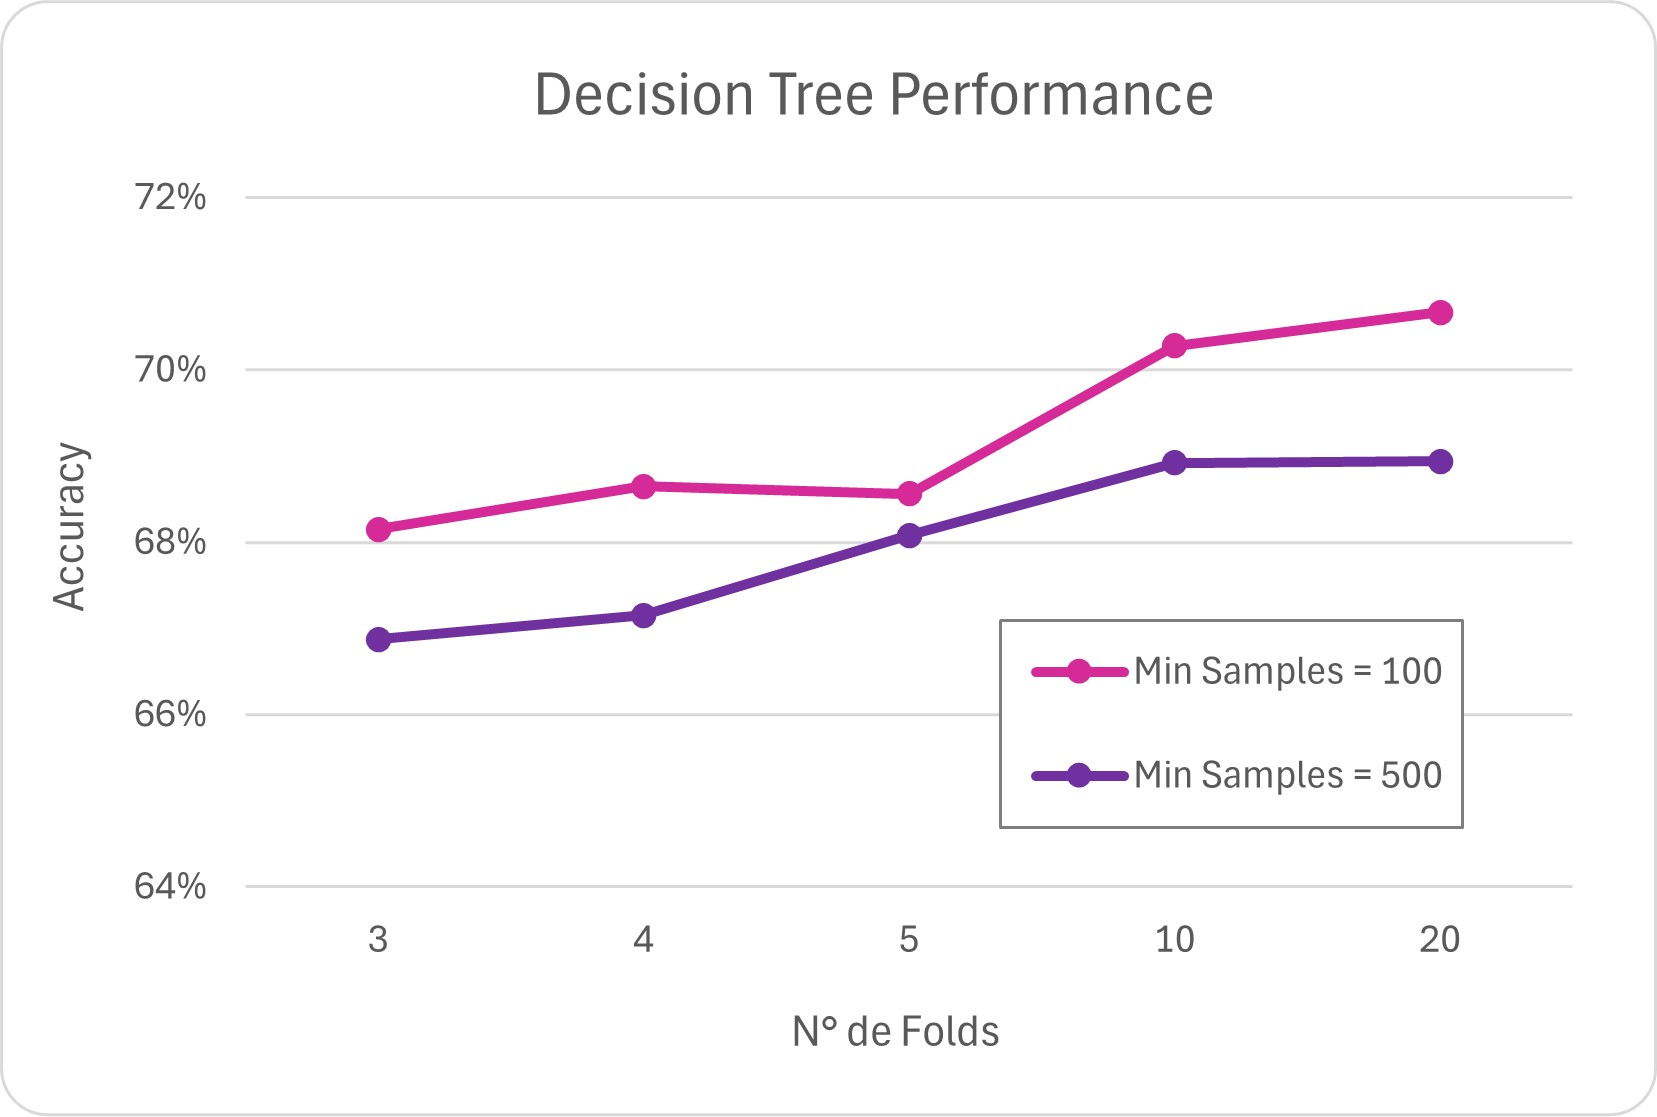
</div>

Assim, optamos por utilizar a árvore com limite = 100 para a implementação da Decision Tree no jogo do Connect4.

---

## Main


In [9]:
IRIS_CSV = 'csv_files/iris.csv'
RESTAURANT_CSV = 'csv_files/restaurant.csv'
WEATHER_CSV = 'csv_files/weather.csv'
CONNECT4_CSV = 'csv_files/connect4.csv'


def main():
    chose_csv = _print_options()
    df = pd.read_csv(chose_csv)

    
    if chose_csv == CONNECT4_CSV:
        dt = load('sophia/dt_connect4.joblib')
    else: 
        df.drop(['ID'], axis=1, inplace=True)

        start = time.time()
        dt = DecisionTree(dataset=df)
        dt.fit(df)
        end = time.time()
        print(end-start)

        StatisticalAnalysis(df)


    target = df.iloc[:,-1]
    colors = {key:value for (value, key) in zip(["#bad9d3", "#d4b4dd", "#fdd9d9"], pd.unique(target))}
    make_dot_representation(dt, colors)

    predict(dt, df)


def _print_options() -> None:
    csvs = {1: 'csv_files/iris.csv',
            2: 'csv_files/restaurant.csv',
            3: 'csv_files/weather.csv',
            4: 'csv_files/connect4.csv'}
    
    print("Choose the dataset to train the Decision Tree:"
            "\n1 - Iris.csv\n"
            "2 - Restaurant.csv\n"
            "3 - Weather.csv\n"
            "4 - Connect4.csv\n")
    chose_csv = int(input("Dataset escolhido: "))
    return csvs[chose_csv]


def predict(dt: DecisionTree, df: DataFrame):
    print("\n\nPREDICTION ---------")
    features = df.iloc[:,:-1] 
    features_names = features.columns
    X_test = []
    for feature in features_names:
        feature_value = input(feature + "? ")
        if feature_value.replace(".", "").isnumeric():
            X_test.append(float(feature_value))
            continue
        if feature_value.upper() == 'FALSE': 
            X_test.append("False")
            continue
        if feature_value.upper() == 'TRUE': 
            X_test.append("True")
            continue
        X_test.append(feature_value)
    
    test = pd.DataFrame([X_test], columns=features_names)
    result = dt.predict(test)[0]
    print("\nPREDICTION: ", result)

In [8]:
def make_dot_representation(dt: DecisionTree, colors: dict) -> None:
    dot_data = "digraph Tree {\nnode [shape=box, style=\"filled, rounded\"] ;\n"
    dot_data += "edge [fontname=\"times\"] ;\n"
    dot_data += _build_dot_node(dt.root, colors)
    dot_data += "}"
    graph = pydotplus.graph_from_dot_data(dot_data)  
    graph.write_png('graph.png')
    Image(graph.create_png())



def _build_dot_node(node: Node, colors: dict) -> str:
    dot_data = ""
    if node.is_leaf:
        color = colors[node.value]
        if node.ispure:
            simbolo = '*'
        else: simbolo = ''
        dot_data += f"{id(node)} [label=\"{node.value}\", xlabel=\"{node.size}{simbolo}\", fillcolor=\"{color}\"] ;\n"
    else:
        dot_data += f"{id(node)} [label=\"{node.feature_name}?\", xlabel=\"{node.size}\"] ;\n"
        for i, child in enumerate(node.children):
            if type(node.value) == np.ndarray:
                split_value = node.value[i]
            else: split_value = node.value
            if node.split_type == 'discrete':
                dot_data += f"{id(node)} -> {id(child)} [label=\"{split_value}\"] ;\n"
            else:
                if i==0: simbolo = '<='
                else: simbolo = '>'
                dot_data += f"{id(node)} -> {id(child)} [label=\"{simbolo}{split_value}\"] ;\n"
            dot_data += _build_dot_node(child, colors)
    return dot_data

---

## Mudanças na implementação para otimização

---

## Connect4 - O jogo

Connect 4, também conhecido como Quatro em Linha, é um jogo de estratégia para dois jogadores. O objetivo é ser o primeiro a alinhar quatro peças da mesma cor consecutivamente, seja na vertical, horizontal ou diagonal, em um tabuleiro vertical com sete colunas e seis linhas. Os jogadores alternam entre si colocando suas peças em uma coluna, tentando bloquear o adversário enquanto procuram formar sua própria sequência de quatro peças.

### Integração com a árvore de decisão

No assigment 1 da matéria, implementamos o connect4 com diferentes tipos de algorítmos de IA, como A*, MCTS e Alphabeta. Utilizando a mesma base de código, integramos a árvore de decisão como um modo de jogo

In [7]:
class DecisionTree:

    def __init__(self) -> None:
        self.dt = load('ai_algorithms/connect4_dt.joblib')
       

    def play(self, board):
        best_moves = []
        average_moves = []
        worst_moves = []
        available_moves = game.available_moves(board)  # Assuming game is an instance of some class

        for col in available_moves:
            temp_board = game.simulate_move(board, c.AI_PIECE, col)  # Assuming c.AI_PIECE is defined
            row = self.map_board_to_csv_row(temp_board)  # Assuming this method is defined
            predict = self.dt.predict(row)
            if predict[0] == 'win': worst_moves.append(col)
            elif predict[0] == 'draw': average_moves.append(col)
            elif predict[0] == 'loss': best_moves.append(col)

        if best_moves:
            return random.choice(best_moves)
        elif average_moves:
            return random.choice(average_moves) 
        elif worst_moves:
            return random.choice(worst_moves)



    def map_board_to_csv_row(self, board):
        flattened_list = [item for sublist in board for item in sublist]
        result = pd.DataFrame([flattened_list])
        result.replace({0: 'b', 1: 'x', 2: 'o'}, inplace = True)
        return result

Nesse código, nós usamos uma instância já pré-treinada de uma árvore de decisão, feita a partir do connect4.csv. O treino desta árvore é demorado e seria inviável treiná-la em tempo de jogo.

A função map_board_to_csv_row() é responsável por parsear uma stade do board (matriz) em uma linha de csv (tupla), assim podendo ser usada pela função predict.

A função pllay é responsãvel por returnar uma jogada em alguma coluna

### Funcionamento (função play())

Quando o oponente faz uma jogada, o estado de jogo é passado como parâmetro para a função play(). Então analisamos em que coluna ainda é possível fazer alguma jogada (com available_moves()), e para cada coluna disponível, simulamos uma jogada em um novo board. Caso as 7 colunas estejam disponíveis, por exemplo, seriam simuladas 7 matrizes com jogadas diferentes. 

Para cada uma dessas matrizes de board, transformamos elas em linhas de csv com o map_board_to_csv_row(), e utilizamos o predict da decision tree para saber se uma jogada é boa ou não. Como na nossa implementação, um humano joga sempre primeiro, e no csv os resultados são para o primeiro player a jogar, uma jogada de vitória no csv significa derrota para o algorítmo. Baseado nisso, adicionamos resultados 'win' como worst_moves, e 'loss' como best_moves

Então retornamos alguma das jogadas possíveis que tenham como resultado 'loss'.

### Desbalanceamento

Como o dataset é desbalanceado, a maioria dos valores retornam 'win', portanto, acaba que a lista de jogadas boas é extensa, e acaba se tornando muito randômico.

Além disso, não conseguimos treinar nossa implementação de árvore com um número menor de 80 min_samples_split, por demorar muito a ser treinado, e o resultado do uso da decision tree, na prática, é pior que o de um greedy. Acreditamos que um número menor de min_samples_splite melhoraria bastante o resultado. 


### Integração com Alpha Beta

A fim de melhorar os resultados da árvore de decisão, modificamos o algorítmo Alpha Beta pra usar decision trees. Como método de pontuação, para cada jogada boa para o algorítmo, retornamos 1, caso contrário, retornamos 0.

In [23]:
HUMAN_PIECE = 1
AI_PIECE = 2

def simulate_move(board: np.ndarray, piece: int, col: int) -> None | np.ndarray:
	"""Simulate a move in a copy of the board"""
	board_copy = board.copy()
	row = get_next_open_row(board_copy, col)
	if row == None: return None
	drop_piece(board_copy, row, col, piece)
	return board_copy

def get_next_open_row(board: np.ndarray, col: int) -> int:
	"""Given a column, return the first row avaiable to set a piece"""
	for row in range(ROWS):
		if board[row][col] == 0:
			return row
	return -1


def available_moves(board: np.ndarray) -> list | int:
	avaiable_moves = []
	for i in range(COLUMNS):
		if(board[5][i])==0:
			avaiable_moves.append(i)
	return avaiable_moves if len(avaiable_moves) > 0 else -1


def winning_move(board: np.ndarray, piece: int) -> bool:
	"""Return if the selected move will win the game"""
	def check_horizontal(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on horizontal lines"""
		for col in range(COLUMNS-3):
			for row in range(ROWS):
				if board[row][col] == piece and board[row][col+1] == piece and board[row][col+2] == piece and board[row][col+3] == piece:
					return True
			

	def check_vertical(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on vertical lines"""
		for col in range(COLUMNS):
			for row in range(ROWS-3):
				if board[row][col] == piece and board[row+1][col] == piece and board[row+2][col] == piece and board[row+3][col] == piece:
					return True
				

	def check_ascending_diagonal(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on ascending diagonal lines"""
		for col in range(COLUMNS-3):
			for row in range(ROWS-3):
				if board[row][col] == piece and board[row+1][col+1] == piece and board[row+2][col+2] == piece and board[row+3][col+3] == piece:
					return True
				

	def check_descending_diagonal(board: np.ndarray, piece: int) -> bool:
		"""Check winning condition on descending diagonal lines"""
		for col in range(COLUMNS-3):
			for row in range(3, ROWS):
				if board[row][col] == piece and board[row-1][col+1] == piece and board[row-2][col+2] == piece and board[row-3][col+3] == piece:
					return True
				
	return check_vertical(board, piece) or check_horizontal(board, piece) or check_ascending_diagonal(board, piece) or check_descending_diagonal(board, piece)
			


In [26]:
from concurrent.futures import ProcessPoolExecutor
import random


class DecisionTree:
    def __init__(self) -> None:
        self.dt = load('connect4_dt.joblib')
       

    def play(self, board):
        worst_moves = []
        available_moves = available_moves(board)
        
        boards = [simulate_move(board, AI_PIECE, col) for col in available_moves]
        rows = pd.concat([self.map_board_to_csv_row(b) for b in boards])
        
        predictions = self.dt.predict(rows)
        worst_moves = [col for col, pred in zip(available_moves, predictions) if pred == 'win']
        
        if worst_moves:
            return random.choice(worst_moves)
        

    def map_board_to_csv_row(self, board):
        flattened_board = np.array(board).flatten()
        converted_board = np.empty_like(flattened_board, dtype=str)

        # Use numpy masks to replace values
        converted_board[flattened_board == 0] = 'b'
        converted_board[flattened_board == 1] = 'x'
        converted_board[flattened_board == 2] = 'o'
        result = pd.DataFrame([converted_board])
        return result


def alpha_beta(board: np.ndarray):
    dt = DecisionTree()
    children = get_children(board, c.AI_PIECE)
    depth_limit = 6
    best_moves = []
    
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(calculate, child, 1, float('-inf'), float('+inf'), depth_limit, False, dt) for (child, col) in children]
        results = [(col, future.result()) for (child, col), future in zip(children, futures)]
    
    for col, score in results:
        if winning_move(board, AI_PIECE): return col
        if score == 1: best_moves.append(col)
    
    if best_moves:
        return random.choice(best_moves)
    else: return random.choice([col for (_, col) in children])
    
    

def calculate(board: np.ndarray, depth: int, alpha: int, beta: int, depth_limit: int, maximizing, dt):
    """Return the accumulated score for the current move"""

    if depth == depth_limit or winning_move(board, 1) or winning_move(board, 2):
        result = dt.play(board) 
        if result is None: return -1
        return 1
    
    if maximizing:
        maxEval = float('-inf')
        children = get_children(board, AI_PIECE)
        for (child, _) in children:
            eval = calculate(child, depth+1, alpha, beta, depth_limit, False, dt)
            maxEval = max(maxEval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return maxEval
    
    else:
        minEval = float('+inf')
        children = get_children(board, HUMAN_PIECE)
        for (child, _) in children:
            eval = calculate(child, depth+1, alpha, beta, depth_limit, True, dt)
            minEval = min(minEval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return minEval


def get_children(board, piece) -> None:
    """Return children of the actual state board"""
    children = []
    if available_moves(board) == -1: return children
    for col in available_moves(board):  
        copy_board = simulate_move(board, piece, col)   
        children.append((copy_board, col)) 
    return children

Na prática, notou-se uma melhora do algorítmo, mas ainda não é capaz de impedir que ganhemos. Nesse sentido, se parece com um algorítmo Greedy. Com uma maior profundidade, o algoritmo tenderia a melhorar, mas 6 de profundidade é o máximo possível no sentido de usabilidade em um jogo, pois com 7 de profundidade, demora-se muito. Utilizamos várias técnicas de optimização, como paralelismo, máscaras numpy para parsear boards em linhas csv e batch simulations para cada coluna possível, mas ainda sim é inviável ficar esperando quase 1 minuto para se fazer uma jogada.

In [ ]:
test_board = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 2, 0, 0],
    [1, 0, 1, 1, 2, 0, 0]
]

col = alpha_beta(test_board)
print(col)